# Granger causality of widely-read books

Working this up quickly; it doesn't really prove "Granger causality" yet; GC in the strict sense only comes up at the end. Instead I'm focused on a different method. We slide two sets relative to each other in time to see where they resemble each other most closely. On the one hand, widely-reviewed/bestselling/prizewinning books; on the other hand, everyone else.

In [1]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cosine
from scipy.stats import pearsonr, spearmanr
from statistics import mean, stdev
from math import sqrt

In [7]:
recep = pd.read_csv('bookswithreception.tsv', sep = '\t')

### Get the top 25% of books with the highest total review wordcount

We do this by creating a column that divides the corpus into quartiles.

In [8]:
recep['quartile'] = pd.qcut(recep.review_wordcount, 4, labels = False)

In [9]:
recep.head()

,docid,tm_author,tm_title,tm_year,review_year,rownum,review_title,prize_author,bestseller_year,is_bestseller,obscure,firstpub,birthyear,us_national,lowest_date,standard_auth,review_wordcount,review_sentiment,quartile
0,uc1.b3347126,"shaw, irwin","welcome to the city, and other",1942.0,1942.0,3289.0,"welcome to the city, and other stories.",False,NaN,False,False,1942,1913.0,True,1942,"shaw, irwin",2400.0,3.715599,2
1,uc1.$b322688,"bennett, arnold",woman who stole everything,1927.0,1927.0,4140.0,"woman who stole everything, and other stories.",False,NaN,False,False,1927,1867.0,False,1927,"bennett, arnold",5010.0,3.500459,3
2,uc1.b3407035,"lippincott, joseph wharton",wilderness champion; the story,1944.0,1944.0,3481.0,wilderness champion; the story of a great houn...,False,NaN,False,False,1944,1887.0,True,1944,"lippincott, joseph w",600.0,3.759941,0
3,uc1.$b116192,"becker, may lamberton",golden tales of the southwest;,1939.0,1939.0,4283.0,golden tales of the southwest; selected with a...,False,NaN,False,False,1939,1873.0,True,1939,"becker, may lamberto",930.0,3.706520,1
4,mdp.39015059415383,"miller, alice duer, mrs",instruments,1926.0,1926.0,2405.0,"instruments of darkness, and other stories.",False,NaN,False,False,1926,1874.0,True,1926,"miller, alice duer,",3600.0,3.613030,2


Our "widely reviewed corpus" will be all books that were in the top 25% plus those that were bestsellers or prizewinners.

In [10]:
widely = recep.loc[(recep.quartile == 3) | (recep.is_bestseller == True) | (recep.prize_author == True), 'docid']

In [11]:
len(widely)

1608

A total of 1608 books.

### Now load the topic proportions for all books

We'll take the ones in widely (widely read) and make them a dataset called "widedata."

In [12]:
data = pd.read_csv('../../cohort/asym/topicdatastandardauths.tsv', sep = '\t', low_memory = False)

In [13]:
widedata = data.loc[data.docid.isin(widely), : ]
widedata.shape

(1608, 209)

Now all the books that we can't prove were widely read.

In [14]:
otherdata = data.loc[(~data.docid.isin(widely)) & (data.firstpub < 1971) & (data.firstpub > 1900), : ]
otherdata.shape

(15722, 209)

In [15]:
len(set(widedata.docid).intersection(set(otherdata.docid)))

0

There should be no books in both.

Now get rid of metadata columns we're not using.

In [16]:
keepcols = ['t' + str(x) for x in range(200)]
keepcols.append('firstpub')

In [17]:
widedata = widedata[keepcols]
widedata.shape

(1608, 201)

In [18]:
otherdata = otherdata[keepcols]
otherdata.shape

(15722, 201)

### Convert our datasets into mean topic vectors for each year

In [19]:
wideyears = widedata.groupby('firstpub').mean()
wideyears.head()

,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,...,t190,t191,t192,t193,t194,t195,t196,t197,t198,t199
firstpub,,,,,,,,,,,,,,,,,,,,,
1916,0.001421,0.005393,0.003457,0.000032,0.007477,0.004149,0.009534,0.004477,0.000739,0.008114,...,0.002799,0.006314,0.000857,0.010612,0.026162,0.001638,0.000339,0.000617,0.000123,0.000095
1917,0.005756,0.007032,0.003457,0.000036,0.008851,0.006280,0.001599,0.006263,0.000791,0.011293,...,0.002256,0.008769,0.002926,0.015879,0.011763,0.002093,0.002672,0.000318,0.000241,0.000161
1918,0.015923,0.004012,0.001691,0.000009,0.007465,0.013479,0.006299,0.004958,0.001369,0.005882,...,0.001123,0.006200,0.000862,0.016185,0.013963,0.005277,0.000793,0.001617,0.000171,0.000078
1919,0.010587,0.007988,0.005209,0.000021,0.008267,0.008551,0.000650,0.007534,0.001691,0.007884,...,0.001575,0.004213,0.001154,0.006233,0.013760,0.003859,0.000766,0.002551,0.000395,0.000228
1920,0.008852,0.008157,0.003489,0.000026,0.009645,0.005667,0.000438,0.008820,0.001028,0.007650,...,0.001011,0.013058,0.002848,0.015345,0.019977,0.002438,0.000222,0.000871,0.000509,0.000036


In [20]:
otheryears = otherdata.groupby('firstpub').mean()
otheryears.tail()

,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,...,t190,t191,t192,t193,t194,t195,t196,t197,t198,t199
firstpub,,,,,,,,,,,,,,,,,,,,,
1966,0.002393,0.001961,0.005098,0.004896,0.007150,0.008464,0.000827,0.002766,0.001199,0.009704,...,0.013969,0.007291,0.015034,0.002237,0.007306,0.005760,0.000600,0.000910,0.006282,0.000417
1967,0.003571,0.001977,0.006653,0.009121,0.007820,0.006043,0.001731,0.002738,0.001818,0.009021,...,0.012893,0.006145,0.014431,0.001922,0.007244,0.003111,0.000524,0.001842,0.005030,0.000458
1968,0.003886,0.001968,0.005802,0.008274,0.007988,0.006757,0.001229,0.001830,0.001305,0.010700,...,0.013903,0.005047,0.015865,0.002485,0.008057,0.006231,0.000252,0.000652,0.006508,0.000564
1969,0.003494,0.001709,0.005165,0.008878,0.007598,0.005230,0.000870,0.002264,0.001674,0.007882,...,0.016079,0.006483,0.011546,0.001878,0.006161,0.003819,0.000388,0.001164,0.005814,0.000467
1970,0.002797,0.001575,0.004949,0.008237,0.008295,0.008069,0.001729,0.002097,0.001477,0.007453,...,0.014935,0.006197,0.010086,0.002363,0.006559,0.003216,0.000287,0.001236,0.015400,0.000341


### Define a function that compares the two at a given offset

We'll call the number of years offset the "lag." A lag of 3 would mean that we're comparing widely-read books from 1930 to the ordinary books in 1933. We'll compare cosine distances between these pairs across the full run of widely-read books from 1916 to 1950. Since we have ordinary books from outside those dates, we can slide a little beyond them, but we aren't necessarily excluding widely-read books when we do — a little source of error there!

At first we're going to run this comparison in the normal way, covering all 200 topics. But notice that we've built in a "mask" that allows us to restrict the comparison to only particular topics by putting ```False``` in places where we want to ignore a column.

In [21]:
def compare_cosinesums(base, target, lag, mask = [True] * 200):
    total = 0
    count = 0
    for year in range(1916, 1951):
        basevec = np.array(base.loc[year, :][0: 200])
        compvec = np.array(target.loc[year + lag, :][0: 200])
        cos = cosine(basevec[mask], compvec[mask])
        total += cos
        count += 1
    return total / count
        

In [22]:
compare_cosinesums(wideyears, otheryears, -2)

0.081057464505934

In [23]:
compare_cosinesums(wideyears, otheryears, -1)

0.07760604374318798

In [24]:
compare_cosinesums(wideyears, otheryears, 0)

0.07448791152336558

In [25]:
compare_cosinesums(wideyears, otheryears, 1)

0.07384174870040426

In [26]:
compare_cosinesums(wideyears, otheryears, 2)

0.07373246429594107

In [27]:
compare_cosinesums(wideyears, otheryears, 3)

0.0738718882682385

**It looks like the low point is a forward lag of 2,** but let's visualize the whole curve to get a sense of things.

In [28]:
laglist = []
cosinelist = []
for lag in range(-10, 11):
    thesum = compare_cosinesums(wideyears, otheryears, lag)
    cosinelist.append(thesum)
    laglist.append(lag)

In [29]:
import seaborn as sns

In [30]:
df = pd.DataFrame({'lag': laglist, 'cos': cosinelist})

In [31]:
sns.set(rc = {'figure.figsize':(8,5)})

Text(0, 0.5, 'avg cosine distance')

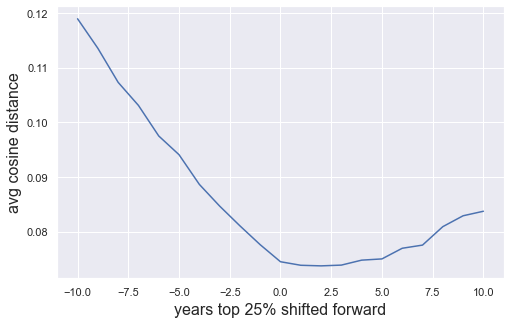

In [32]:
j = sns.lineplot(x = 'lag', y = 'cos', data = df)
j.set_xlabel('years top 25% shifted forward',fontsize=16)
j.set_ylabel('avg cosine distance',fontsize=16)

#### What's very interesting about that is the difference in slope.

## Now let's only use certain topics

In particular we're going to use the data Wenyi, Kevin, Stephen and I produced about topics last year -- especially Kevin's structural equation modeling.

Read in the metadata about topics ("topic summary").

In [34]:
topicsum = pd.read_csv('../../cohort/topic_summary.tsv', sep = '\t')
topicsum.head(3)

,label,category,topicsize,delta,r2,sem_verdict,cohortmse,periodmse,agemse,delta_oos,r2_oos,cohortr2_oos,periodr2_oos,keywords,top7books,"next5books, biggestauth, datequartiles",comments
0,"war, mostly WWII",event,0.267,0.052664,0.047869,SDM,11.6860,209.5212,0.53325,0.078345,0.024379,0.020000,0.102817,war german french germans france germany ameri...,"0.136 | Gibbs, Philip | Through the storm | 19...","0.12 | Sweetser, Arthur | Roadside glimpses of...","Although hitler and nazi are keywords, we can ..."
1,"e20c scientists, labs, and professors, mostly ...",genre,0.288,0.578712,0.017090,Inconclusive,25.0768,16.0822,2.13175,0.689357,0.003942,0.061597,0.017510,professor man quite something thing old little...,"0.177 | Stewart, J. I. M. (John Innes | Hare ...","0.147 | Wells, H. G. (Herbert George) | Star-b...",I've changed my mind here twice. The topic is ...
2,"objects in relation to doors, pockets, rooms, ...",physical description,0.479,0.642251,0.006939,AUM,16.1334,9.5950,2.73375,0.433169,-0.004519,0.012027,0.011970,door put box paper hand took room went made po...,"0.489 | Sellers, Tom | Unknown Title | 1927 0....","0.122 | Axline, Virginia Mae | Dibs: in search...","Notice relatively high document entropy, and ..."


**Construct masks** that only include topics where we found "active updating" (writers changed in durable ways) or "settled dispositions" (they didn't).

In [37]:
sdmmask = topicsum.sem_verdict == 'SDM'
aummask = topicsum.sem_verdict == 'AUM'

In [43]:
print(sum(sdmmask), " settled dispositions.")
print(sum(aummask), " active updaters.")

57  settled dispositions.
128  active updaters.


### Using only updating topics, we get a similar result

In [39]:
laglist = []
cosinelist = []
for lag in range(-10, 11):
    thesum = compare_cosinesums(wideyears, otheryears, lag, aummask)
    cosinelist.append(thesum)
    laglist.append(lag)

Text(0.5, 1.0, 'Only topics that show active updating.')

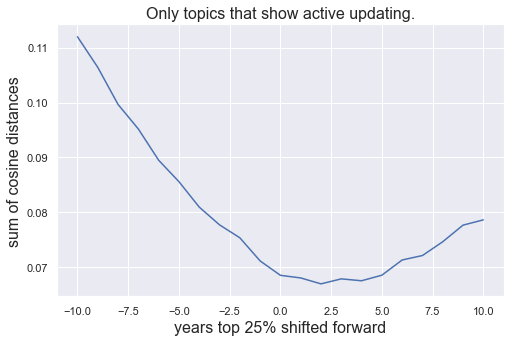

In [40]:
df = pd.DataFrame({'lag': laglist, 'cos': cosinelist})
j = sns.lineplot(x = 'lag', y = 'cos', data = df)
j.set_xlabel('years top 25% shifted forward',fontsize=16)
j.set_ylabel('sum of cosine distances',fontsize=16)
j.set_title('Only topics that show active updating.', fontsize = 16)

### But using only topics with settled dispositions ...

In [41]:
laglist = []
cosinelist = []
for lag in range(-10, 11):
    thesum = compare_cosinesums(wideyears, otheryears, lag, sdmmask)
    cosinelist.append(thesum)
    laglist.append(lag)

Text(0.5, 1.0, 'Only topics with settled dispositions.')

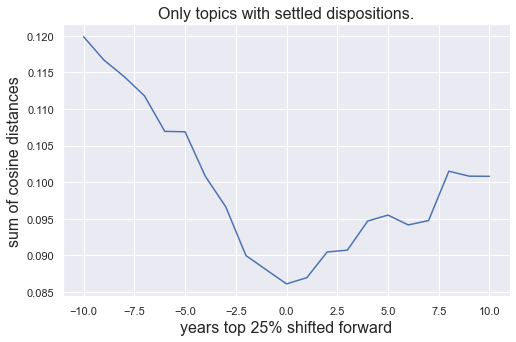

In [42]:
df = pd.DataFrame({'lag': laglist, 'cos': cosinelist})
j = sns.lineplot(x = 'lag', y = 'cos', data = df)
j.set_xlabel('years top 25% shifted forward',fontsize=16)
j.set_ylabel('sum of cosine distances',fontsize=16)
j.set_title('Only topics with settled dispositions.', fontsize = 16)

#### I've stopped commenting the code here.

In [99]:
cosinelist.index(min(cosinelist))

17

In [64]:
lagstrengths = []

for t in range(200):
    variable = 't' + str(t)
    thediffs = []
    for slip in range(2, 4):
        baserun = wideyears.loc[[x for x in range(1916, 1951)] , variable]
        target0 = otheryears.loc[[x for x in range(1916, 1951)], variable]
        target1 = otheryears.loc[[x for x in range(1916 + slip, 1951 + slip)], variable]
        straight_r, p = pearsonr(baserun, target0)
        lag_r, p = pearsonr(baserun, target1)
        diff = np.arctanh(lag_r) - np.arctanh(straight_r)
        thediffs.append(diff)
    lagstrengths.append(max(thediffs))

In [46]:
topicsum = pd.read_csv('../topic_summary.tsv', sep = '\t')
topicsum.head()

,label,category,topicsize,delta,r2,sem_verdict,cohortmse,periodmse,agemse,delta_oos,r2_oos,cohortr2_oos,periodr2_oos,keywords,top7books,"next5books, biggestauth, datequartiles",comments
0,"war, mostly WWII",event,0.267,0.052664,0.047869,SDM,11.6860,209.5212,0.53325,0.078345,0.024379,0.020000,0.102817,war german french germans france germany ameri...,"0.136 | Gibbs, Philip | Through the storm | 19...","0.12 | Sweetser, Arthur | Roadside glimpses of...","Although hitler and nazi are keywords, we can ..."
1,"e20c scientists, labs, and professors, mostly ...",genre,0.288,0.578712,0.017090,Inconclusive,25.0768,16.0822,2.13175,0.689357,0.003942,0.061597,0.017510,professor man quite something thing old little...,"0.177 | Stewart, J. I. M. (John Innes | Hare ...","0.147 | Wells, H. G. (Herbert George) | Star-b...",I've changed my mind here twice. The topic is ...
2,"objects in relation to doors, pockets, rooms, ...",physical description,0.479,0.642251,0.006939,AUM,16.1334,9.5950,2.73375,0.433169,-0.004519,0.012027,0.011970,door put box paper hand took room went made po...,"0.489 | Sellers, Tom | Unknown Title | 1927 0....","0.122 | Axline, Virginia Mae | Dibs: in search...","Notice relatively high document entropy, and ..."
3,late 20c US political thrillers,genre,0.388,0.238089,0.136532,AUM,46.8034,151.2078,9.89675,0.140974,0.122522,0.029488,0.198506,american people president our security re new ...,"0.297 | Digo, Benjamin | Creator of Nikho | 19...","0.243 | Clancy, Tom | The sum of all fears | 1...","Low doc entropy, high number of rank-1 docs; t..."
4,diffuse,uncategorized dimension of style,0.666,0.783425,0.028121,AUM,61.5444,17.3744,4.91075,0.809441,0.011077,0.078168,0.020837,man old people men because knew good always bi...,"0.157 | Hanley, Gerald | Drinkers of darkness ...","0.123 | Onadipe, Kola | The king is naked : an...",A pretty diffuse topic. The books come from di...


In [36]:
spearmanr(lagstrengths, topicsum.delta)

NameError: name 'lagstrengths' is not defined

In [70]:
tuplelist = [x for x in zip(lagstrengths, [x for x in range(200)])]
tuplelist.sort(reverse = True)
tuplelist[0:10]

[(0.5656210338418408, 58),
 (0.5443652364470329, 170),
 (0.5348324125235472, 144),
 (0.502352935835783, 194),
 (0.47623557275669615, 166),
 (0.46952013213189814, 35),
 (0.40628245780909994, 32),
 (0.3917310779826605, 101),
 (0.3874050327685594, 157),
 (0.38024213037437693, 169)]

In [66]:
lagstrengths[0]

-0.8551245929016215

In [79]:
df = pd.DataFrame(index = [x for x in range(1916, 1951)], 
                  data = {'famous': wideyears.loc[[x for x in range(1916, 1951)] , 't194'],
                 'baseline': otheryears.loc[[x for x in range(1916, 1951)] , 't194']})

<AxesSubplot:>

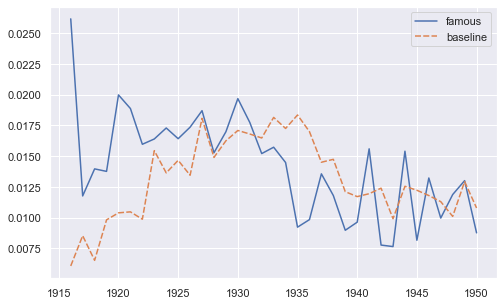

In [80]:
sns.lineplot(data = df)

<AxesSubplot:>

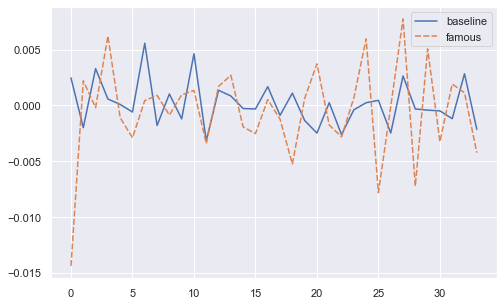

In [82]:
df2 = pd.DataFrame(data = {'baseline': np.diff(df.baseline),
                          'famous': np.diff(df.famous)})
sns.lineplot(data = df2)

In [86]:
print(len(df), len(df2))

35 34


In [83]:
from statsmodels.tsa.stattools import grangercausalitytests

In [84]:
grangercausalitytests(df2, 3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5863  , p=0.2176  , df_denom=30, df_num=1
ssr based chi2 test:   chi2=1.7449  , p=0.1865  , df=1
likelihood ratio test: chi2=1.7003  , p=0.1922  , df=1
parameter F test:         F=1.5863  , p=0.2176  , df_denom=30, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.9182  , p=0.1664  , df_denom=27, df_num=2
ssr based chi2 test:   chi2=4.5468  , p=0.1030  , df=2
likelihood ratio test: chi2=4.2515  , p=0.1193  , df=2
parameter F test:         F=1.9182  , p=0.1664  , df_denom=27, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7271  , p=0.5458  , df_denom=24, df_num=3
ssr based chi2 test:   chi2=2.8177  , p=0.4206  , df=3
likelihood ratio test: chi2=2.6969  , p=0.4408  , df=3
parameter F test:         F=0.7271  , p=0.5458  , df_denom=24, df_num=3


{1: ({'ssr_ftest': (1.5862890162569565, 0.2175682827786039, 30.0, 1),
   'ssr_chi2test': (1.7449179178826522, 0.18651689854413228, 1),
   'lrtest': (1.7003498450989127, 0.19224223136015842, 1),
   'params_ftest': (1.5862890162569583, 0.2175682827786039, 30.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.9181896261446132, 0.16636241198541746, 27.0, 2),
   'ssr_chi2test': (4.546819854565009, 0.10296049301605531, 2),
   'lrtest': (4.2514646888832885, 0.1193455342160887, 2),
   'params_ftest': (1.9181896261446163, 0.1663624119854169, 27.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.7271438893084251, 0.5457947129222911, 24.0, 3),
   'ssr_chi2test': (2.817682571070147, 0.4205973171907246, 3),
   'lrtest': (2.696895040114839, 0.4407552076790646, 3),
   'params_ftest': (0.727143889308426, 0.5457947129222906, 24.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0.

In [87]:
from scipy.stats import ttest_ind

In [88]:
lagstrengths = np.array(lagstrengths)

In [89]:
sdmmask = topicsum.sem_verdict == 'SDM'

In [90]:
aummask = topicsum.sem_verdict == 'AUM'

In [119]:
ttest_ind(lagstrengths[sdmmask], lagstrengths[aummask])

Ttest_indResult(statistic=-1.4148664769872805, pvalue=0.15880697160812093)

In [116]:
np.mean(lagstrengths)

0.04384448029963334

In [120]:
def cohens_d(a, b):
    cohens_d = (mean(a) - mean(b)) / (sqrt((stdev(a) ** 2 + stdev(b) ** 2) / 2))
    return cohens_d

In [123]:
cohens_d(lagstrengths[sdmmask], lagstrengths[aummask])

-0.21370369783836088

In [126]:
df = pd.DataFrame({'a': np.diff(otheryears.loc[[x for x in range(1916, 1951)], 't5']), 
                   'b': np.diff(wideyears.loc[[x for x in range(1916, 1951)], 't5'])})

In [127]:
df.head()

,a,b
0,0.000552,0.002130
1,0.003815,0.007199
2,0.000719,-0.004928
3,-0.001400,-0.002884
4,-0.001712,0.001339


In [132]:
j = grangercausalitytests(df, 3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3759  , p=0.5444  , df_denom=30, df_num=1
ssr based chi2 test:   chi2=0.4135  , p=0.5202  , df=1
likelihood ratio test: chi2=0.4109  , p=0.5215  , df=1
parameter F test:         F=0.3759  , p=0.5444  , df_denom=30, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.3309  , p=0.0056  , df_denom=27, df_num=2
ssr based chi2 test:   chi2=15.0065 , p=0.0006  , df=2
likelihood ratio test: chi2=12.3056 , p=0.0021  , df=2
parameter F test:         F=6.3309  , p=0.0056  , df_denom=27, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.1166  , p=0.0071  , df_denom=24, df_num=3
ssr based chi2 test:   chi2=19.8269 , p=0.0002  , df=3
likelihood ratio test: chi2=15.3276 , p=0.0016  , df=3
parameter F test:         F=5.1166  , p=0.0071  , df_denom=24, df_num=3


In [137]:
j[3][0]['ssr_chi2test'][1]

0.00018435768239818037

In [156]:
causal = []

for i in range(200):
    variable = 't' + str(i)
    df = pd.DataFrame({'a': np.diff(otheryears.loc[[x for x in range(1916, 1951)], variable]), 
                   'b': np.diff(wideyears.loc[[x for x in range(1916, 1951)], variable])})
    j = grangercausalitytests(df, 2, verbose = False)
    result = j[2][0]['ssr_chi2test'][1]
    if result < 0.05:
        causal.append(True)
    else:
        causal.append(False)

In [157]:
sum(causal)

22

In [158]:
df = pd.DataFrame({'causal': causal, 'sem': topicsum.sem_verdict})
conttable = pd.crosstab(index = df['causal'], columns = df['sem'])

In [159]:
conttable

sem,AUM,Inconclusive,SDM
causal,,,
False,110,14,54
True,18,1,3


In [160]:
from scipy.stats import chi2_contingency

In [161]:
conttable = conttable[["AUM", "SDM"]]
conttable

sem,AUM,SDM
causal,,
False,110,54
True,18,3


In [162]:
chi2_contingency(conttable)

(2.2231007941761165,
 0.1359597521752824,
 1,
 array([[113.47027027,  50.52972973],
        [ 14.52972973,   6.47027027]]))

In [163]:
topicsum.loc[causal, : ]

,label,category,topicsize,delta,r2,sem_verdict,cohortmse,periodmse,agemse,delta_oos,r2_oos,cohortr2_oos,periodr2_oos,keywords,top7books,"next5books, biggestauth, datequartiles",comments
5,"ambitious European writers, in translation",genre,0.621,0.712378,0.018034,AUM,63.4240,25.0298,4.689250,0.625877,-0.004280,0.052841,0.029163,without little eyes same those day even everyt...,"0.308 | D'Annunzio, Gabriele | The intruder | ...","0.226 | Rod, Edouard | The sacrifice of silenc...",This one is really very puzzling. French and I...
12,"physical sensation, mid-20c",physical description,0.754,0.619664,0.110491,AUM,110.3678,68.5130,5.738000,0.526984,0.094749,0.121199,0.110291,face eyes voice against felt its dark small mo...,"0.134 | Hayes, Joseph | The third day | 1964 0...","0.123 | Bates, H. E. (Herbert Ernest) | Dear l...",NaN
34,late 19c romantic historical fiction,genre,0.858,0.677866,0.124532,AUM,152.4576,57.6310,4.170750,0.747013,0.091452,0.189421,0.043553,am shall may must upon should man know take ca...,"0.236 | Koenig, Ewald August | Wooing a widow....","0.176 | Ainsworth, William Harrison | Guy Fawk...",Here I'm guided mostly by author names.
37,art and artists,"human institutions, practices, or relationships",0.159,0.789757,0.006104,AUM,15.9856,4.6900,2.767000,0.819931,-0.001768,0.017746,0.007321,art picture work artist painting studio pictur...,"0.282 | Fearing, Kelly | Our expanding vision ...","0.099 | Frith, William Powell | My autobiograp...",NaN
43,late 20c SF,genre,0.375,0.643037,0.094232,AUM,172.7332,55.5734,4.245250,0.263590,0.041075,0.154036,0.286741,earth ship space its planet human years system...,"0.399 | Herbert, Frank | Destination, void | 1...","0.287 | Shatner, William | Star Trek : the ret...",Huge number of rank 1 docs; high coherence; th...
62,"late-19c family life, largely Trollope",author-dominated,0.463,0.704200,0.033970,AUM,28.9126,12.1154,0.178000,0.398005,0.023823,0.015439,0.020961,sister brother should such must house own upon...,"0.345 | Trollope, Anthony | Kept in the dark |...","0.283 | Trollope, Anthony | An old man's love,...",The cut-off for author-dominated is roughly he...
64,informal diction,uncategorized dimension of style,1.537,0.284677,0.041899,AUM,42.3886,108.7322,5.970000,0.324216,0.027575,0.055585,0.115956,get re know think going just got want right ca...,"0.298 | Simmons, Patricia Worth | Yesterday's ...","0.199 | Lardner, Ring | Treat 'em rough | 1918...",NaN
70,matter-of-fact journalistic language in advent...,uncategorized dimension of style,1.127,0.548753,0.146111,Inconclusive,73.6266,55.9138,0.107442,0.587443,0.121455,0.101339,0.067572,upon while being until soon found made few hav...,"0.279 | Pinkerton, Allan | The burglar's fate ...","0.21 | Eric, Allan | A Yankee Crusoe; or, The ...",Note the long average word length. Pinkerton i...
75,passage of time,physical description,0.764,0.741445,0.022977,AUM,36.6232,15.7282,10.073500,0.827155,0.004459,0.038935,0.023575,day three years night five first four morning ...,"0.398 | Watson, Nancy Dingman | What is one? |...","0.081 | Kawabata, Yasunari | Japan the beautif...",NaN
103,family,"human institutions, practices, or relationships",0.598,0.720845,0.024291,AUM,79.2244,30.6994,5.563000,0.608994,0.009703,0.071304,0.046311,woman old man wife husband young years women c...,"0.132 | Lear, Edward | The book of nonsense to...","0.085 | Bogoras, Waldemar | Tales of Yukaghir,...",NaN
